In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
import gymnasium as gym

from astropy.io import fits
from datetime import datetime
import json
# import fitsio
import pandas as pd
import time
import pickle
import re


%reload_ext autoreload
%autoreload 2

In [2]:
import survey_ops
from survey_ops.utils import units, geometry, interpolate
from survey_ops.src.offline_dataset import OfflineDECamDataset
from survey_ops.src.agents import Agent
from survey_ops.src.algorithms import DDQN, BehaviorCloning
from survey_ops.utils.pytorch_utils import seed_everything


In [3]:
SEED = 10
seed_everything(SEED)
torch.set_default_dtype(torch.float32)
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"   
)

# Load and cut data from fits file, save as .json

In [4]:
data_json_fn = '../data/data_w_dith.json'
data_fits_fn = '../data/decam-exposures-20251211_w_dith.fits'

try:
    # --- Load json df ---- #
    df = pd.read_json(data_json_fn)
    print('Loaded data from json')
except:
    # --- Load fits ---- #
    print(data_json_fn, 'DNE. Loading and processing data from fits.')
    d = fitsio.read(data_fits_fn)
    sel = (d['propid'] == '2012B-0001') & (d['exptime'] > 40) & (d['exptime'] < 100) & (~np.isnan(d['teff']))
    selected_d = d[sel]
    column_names = selected_d.dtype.names
    df = pd.DataFrame(selected_d, columns=column_names)
    
    # mask = np.array([False if 'None' in dt else True for dt in subs_data['datetime']])
    # subs_data = {key: subs_data[key][mask] for key in subs_data.keys()}
    
    df.to_json(data_json_fn, indent=2)
    df = pd.read_json(data_json_fn)
    

Loaded data from json


In [5]:
# In order to get fields (ra, dec) in bin for any timestamp:
# inputs are df, time
# Map ra, dec to az, el given time
# Map az, el to bin

In [6]:
object_radec_df = df[['object', 'ra', 'dec']]

In [7]:
object_radec_groups = object_radec_df.groupby('object')

In [13]:
obj_name

NameError: name 'obj_name' is not defined

In [95]:
df.copy(deep=True)

,expnum,ra,dec,exptime,filter,propid,program,object,teff,fwhm,datetime,az,zd,ha,airmass,qc_fwhm,qc_cloud,qc_sky,qc_teff
0,229250,301.199042,-50.938332,90,g,2012B-0001,survey,DES survey hex -579-501 tiling 3,0.41,1.15,2013-08-31 23:55:07,139.5500,32.21,-33.208458,1.18,1.15,0.42,1.26,0.41
1,229251,300.851117,-52.967276,90,g,2012B-0001,survey,DES survey hex -582-521 tiling 3,0.60,1.18,2013-08-31 23:57:08,143.3200,32.76,-32.380917,1.19,1.18,0.15,1.23,0.60
2,229252,300.460079,-54.996221,90,g,2012B-0001,survey,DES survey hex -586-542 tiling 3,0.62,1.17,2013-08-31 23:59:08,146.9500,33.42,-31.494500,1.20,1.17,-0.07,1.22,0.62
3,229253,300.016742,-57.024887,90,g,2012B-0001,survey,DES survey hex -590-562 tiling 3,0.52,1.29,2013-09-01 00:01:11,150.4500,34.21,-30.536042,1.21,1.29,-0.21,1.20,0.52
4,229254,302.722079,-58.040193,90,g,2012B-0001,survey,DES survey hex -563-572 tiling 3,0.44,1.40,2013-09-01 00:03:13,150.5900,35.76,-32.738375,1.23,1.40,0.04,1.20,0.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88613,810366,58.930033,-42.303110,90,r,2012B-0001,des_celeb,NGC 1487,0.55,1.35,2019-01-10 04:27:33,238.7702,38.66,46.306458,1.28,1.35,0.09,-0.15,0.55
88614,810367,58.929917,-42.303138,90,i,2012B-0001,des_celeb,NGC 1487,0.51,1.16,2019-01-10 04:29:31,238.7969,39.02,46.803625,1.29,1.16,0.08,0.19,0.51
88615,810370,53.414579,-36.057110,45,i,2012B-0001,des_celeb,NGC 1365,0.30,1.41,2019-01-10 04:35:39,247.6877,44.83,53.840917,1.41,1.41,0.08,0.34,0.30
88616,810371,53.389708,-36.223610,45,g,2012B-0001,des_celeb,NGC 1365,0.46,1.59,2019-01-10 04:36:53,247.3923,45.09,54.204458,1.42,1.59,0.12,-0.18,0.46


In [21]:
df_filtered = df.copy(deep=True)
outlier_indices = []
for obj_name, g in object_radec_groups:
    # print(g.index)

    cutoff_deg = 3
    median_ra = g.ra.median()
    delta_ra = g.ra - median_ra
    delta_ra_shifted = np.remainder(delta_ra + 180, 360) - 180
    mask_outlier_ra = np.abs(delta_ra_shifted) > cutoff_deg

    median_dec = g.dec.median()
    delta_dec = g.dec - median_dec
    delta_dec_shifted = np.remainder(delta_dec + 180, 360) - 180
    mask_outlier_dec = np.abs(delta_dec_shifted) > cutoff_deg

    mask_outlier = mask_outlier_ra | mask_outlier_dec

    if np.count_nonzero(mask_outlier) > 0:
        indices = g.index[mask_outlier].values
        outlier_indices.extend(indices)
        

df_filtered.loc[outlier_indices, 'object'] = [f'{obj_name} (outlier)' for obj_name in df.loc[outlier_indices, 'object'].values]


In [15]:
df_filtered.loc[outlier_indices, 'object'].values

array(['DES survey hex -184-552 tiling 2 (outlier)',
       'DES survey hex -287-511 tiling 1 (outlier)',
       'DES survey hex -302-572 tiling 2 (outlier)',
       'DES survey hex 10-390 tiling 4 (outlier)',
       'DES survey hex 106-562 tiling 3 (outlier)',
       'DES survey hex 11-592 tiling 2 (outlier)',
       'DES survey hex 11-592 tiling 2 (outlier)',
       'DES survey hex 133-308 tiling 4 (outlier)',
       'DES survey hex 244-14 tiling 2 (outlier)',
       'DES survey hex 307+47 tiling 5 (outlier)',
       'DES survey hex 4+37 tiling 3 (outlier)',
       'DES survey hex 4-24 tiling 3 (outlier)',
       'DES survey hex 4-4 tiling 3 (outlier)',
       'DES survey hex 4-4 tiling 3 (outlier)',
       'DES survey hex 4-45 tiling 3 (outlier)',
       'DES survey hex 485-166 tiling 9 (outlier)',
       'DES survey hex 698-501 tiling 10 (outlier)',
       'DES survey hex 748-501 tiling 10 (outlier)',
       'DES survey hex 919-491 tiling 7 (outlier)',
       'DES survey hex 932-36

In [16]:
[f'{obj_name} (outlier)' for obj_name in df.loc[outlier_indices, 'object'].values]

['DES survey hex -184-552 tiling 2 (outlier)',
 'DES survey hex -287-511 tiling 1 (outlier)',
 'DES survey hex -302-572 tiling 2 (outlier)',
 'DES survey hex 10-390 tiling 4 (outlier)',
 'DES survey hex 106-562 tiling 3 (outlier)',
 'DES survey hex 11-592 tiling 2 (outlier)',
 'DES survey hex 11-592 tiling 2 (outlier)',
 'DES survey hex 133-308 tiling 4 (outlier)',
 'DES survey hex 244-14 tiling 2 (outlier)',
 'DES survey hex 307+47 tiling 5 (outlier)',
 'DES survey hex 4+37 tiling 3 (outlier)',
 'DES survey hex 4-24 tiling 3 (outlier)',
 'DES survey hex 4-4 tiling 3 (outlier)',
 'DES survey hex 4-4 tiling 3 (outlier)',
 'DES survey hex 4-45 tiling 3 (outlier)',
 'DES survey hex 485-166 tiling 9 (outlier)',
 'DES survey hex 698-501 tiling 10 (outlier)',
 'DES survey hex 748-501 tiling 10 (outlier)',
 'DES survey hex 919-491 tiling 7 (outlier)',
 'DES survey hex 932-369 tiling 3 (outlier)',
 'guided (outlier)']

In [17]:
np.count_nonzero(df_filtered.object.str.contains('outlier'))

np.int64(21)

In [ ]:
# df.loc[mask, 'base_object'] = df.loc[mask, 'object'].str.extract(pattern, expand=False)


In [18]:
df_filtered = df_filtered.drop(outlier_indices)

In [19]:
len(df_filtered)

88597

In [173]:
len(df) - len(df_filtered)

21

In [174]:
len(outlier_indices)

21

In [22]:
groups.get_group('DES survey hex 11-592 tiling 3')

NameError: name 'groups' is not defined

In [127]:
groups.object == 'DES survey hex 11-592 tiling 3'

False

In [23]:
df_dropped_outliers = df.drop('row2')

KeyError: "['row2'] not found in axis"

In [70]:
for g in object_radec_groups.groups:
    print(g.indices)
    break

AttributeError: 'str' object has no attribute 'indices'

In [51]:
groups = df.groupby('object')

In [63]:
groups.nth(1)

,expnum,ra,dec,exptime,filter,propid,program,object,teff,fwhm,datetime,az,zd,ha,airmass,qc_fwhm,qc_cloud,qc_sky,qc_teff
35,229286,301.198950,-50.937665,90,r,2012B-0001,survey,DES survey hex -579-501 tiling 3,0.51,1.11,2013-09-01 01:15:03,158.2900,22.94,-13.171250,1.09,1.11,0.15,3.69,0.51
42,229293,300.851371,-52.966582,90,r,2012B-0001,survey,DES survey hex -582-521 tiling 3,0.78,0.91,2013-09-01 01:31:05,166.6200,23.65,-8.818292,1.09,0.91,0.01,3.61,0.78
46,229297,306.056279,-52.966610,90,r,2012B-0001,survey,DES survey hex -530-521 tiling 3,0.82,0.90,2013-09-01 01:40:44,162.7900,24.28,-11.599083,1.10,0.90,-0.01,3.52,0.82
47,229298,303.324992,-53.981971,90,r,2012B-0001,survey,DES survey hex -558-532 tiling 3,0.71,0.97,2013-09-01 01:42:43,168.0200,24.53,-8.374167,1.10,0.97,0.00,3.50,0.71
50,229301,303.574200,-51.952471,90,r,2012B-0001,survey,DES survey hex -555-511 tiling 3,0.81,0.89,2013-09-01 01:48:45,168.3700,22.36,-7.101125,1.08,0.89,0.14,3.62,0.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88486,809774,43.826746,-66.882220,90,g,2012B-0001,survey,DES survey hex 458-674 tiling 2,0.64,1.39,2019-01-08 02:54:01,200.0261,42.48,36.086417,1.35,1.39,0.11,-0.24,0.64
88487,809775,63.086879,-66.932998,90,g,2012B-0001,survey,DES survey hex 611-674 tiling 9,0.88,1.20,2019-01-08 02:56:46,190.9898,38.20,17.590750,1.27,1.20,0.09,-0.28,0.88
88573,810322,41.159533,-66.476387,90,r,2012B-0001,survey,DES survey hex 418-663 tiling 8,0.85,1.03,2019-01-10 02:55:59,202.3400,43.85,41.238042,1.39,1.03,0.04,-0.03,0.85
88607,810357,58.954950,-42.284693,90,r,2012B-0001,des_celeb,NGC 1487,0.87,1.08,2019-01-10 04:14:01,238.5064,36.13,42.889208,1.24,1.08,0.09,-0.16,0.87


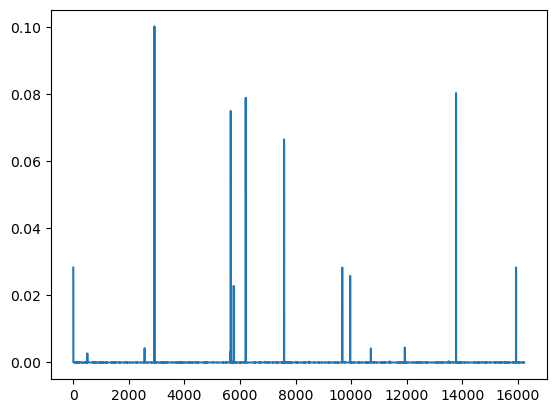

In [47]:
plt.plot(np.array(dith_areas)[np.array(dith_areas) < 1])

In [54]:
error_fields

['DES survey hex -302-572 tiling 2',
 'DES survey hex 106-562 tiling 3',
 'DES survey hex 4-24 tiling 3',
 'DES survey hex 748-501 tiling 10',
 'DES survey hex 10-390 tiling 4',
 'DES survey hex 485-166 tiling 9',
 'DES survey hex -184-552 tiling 2',
 'DES survey hex 4+37 tiling 3',
 'DES survey hex -287-511 tiling 1',
 'DES survey hex 11-592 tiling 2',
 'DES survey hex 698-501 tiling 10',
 'DES survey hex 133-308 tiling 4',
 'DES survey hex 4-45 tiling 3',
 'DES survey hex 919-491 tiling 7']

Check out fields which have very large dithering areas

In [55]:
mask = df['object'].isin(error_fields)

In [56]:
extracted_rows = df[mask]

In [57]:
one_tiling = extracted_rows[extracted_rows['object'].str.contains(error_fields[0])]

In [61]:
np.sort(one_tiling.ra)

array([328.396246, 328.396408, 328.396454, 328.396483, 328.396529,
       328.396529, 328.396575, 349.705033])

In [59]:
[(obj, ra, dec) for obj, ra, dec in zip(one_tiling.object, one_tiling.ra, one_tiling.dec)]

[('DES survey hex -302-572 tiling 2', 328.396408, -56.737859),
 ('DES survey hex -302-572 tiling 2', 328.396454, -56.737471),
 ('DES survey hex -302-572 tiling 2', 328.396483, -56.737471),
 ('DES survey hex -302-572 tiling 2', 328.396246, -56.737693),
 ('DES survey hex -302-572 tiling 2', 328.396575, -56.737582),
 ('DES survey hex -302-572 tiling 2', 349.705033, -46.592665),
 ('DES survey hex -302-572 tiling 2', 328.396529, -56.737526),
 ('DES survey hex -302-572 tiling 2', 328.396529, -56.737526)]

In [60]:
np.mean(one_tiling.ra)

np.float64(331.060032125)

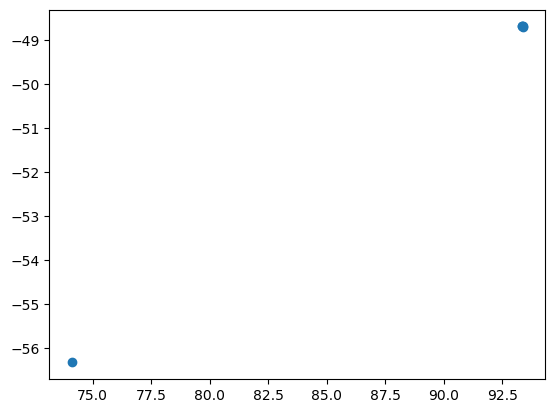

In [44]:
plt.scatter(one_tiling.ra, one_tiling.dec)

# Instantiate the offline dataset choosing binning method (healpix vs uniform_grid)

In [8]:
dataset = OfflineDECamDataset(
    df, 
    binning_method='healpix',
    nside=8,
    bin_space='radec',
    specific_years=[2014],
    specific_months=[12],
    specific_days=[15],
    include_bin_features=False
)

In [9]:
dataset.state_feature_names

['ra_cos',
 'ra_sin',
 'dec',
 'az_cos',
 'az_sin',
 'el',
 'airmass',
 'ha_cos',
 'ha_sin',
 'sun_ra_cos',
 'sun_ra_sin',
 'sun_dec',
 'sun_az_cos',
 'sun_az_sin',
 'sun_el',
 'moon_ra_cos',
 'moon_ra_sin',
 'moon_dec',
 'moon_az_cos',
 'moon_az_sin',
 'moon_el',
 'time_fraction_since_start',
 'time_seconds_since_start']

In [10]:
# have ra, dec, object
# want such that we select bin, and then get field_ids
# want field/object name to ra, decs

# Visualize dataset in az, el and ra, dec

In [11]:
obj_names, counts = np.unique(dataset._df.object, return_counts=True)

Text(0, 0.5, 'Number of fields')

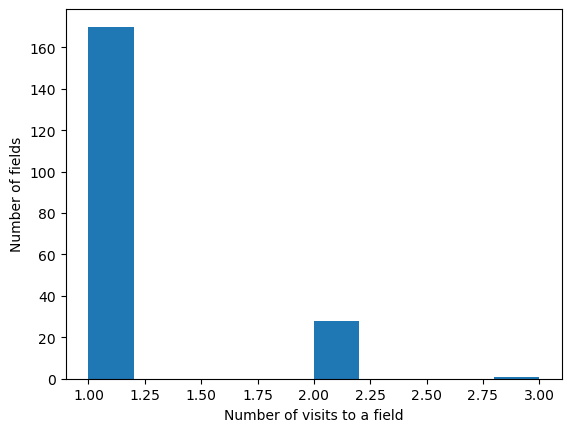

In [12]:
plt.hist(counts)
plt.xlabel('Number of visits to a field')
plt.ylabel('Number of fields')

Text(0.5, 0, 'Number of observations in a night')

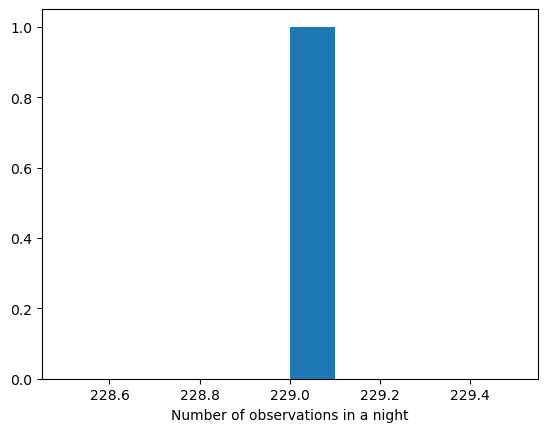

In [13]:
plt.hist(dataset.n_obs_per_night)
plt.xlabel('Number of observations in a night')

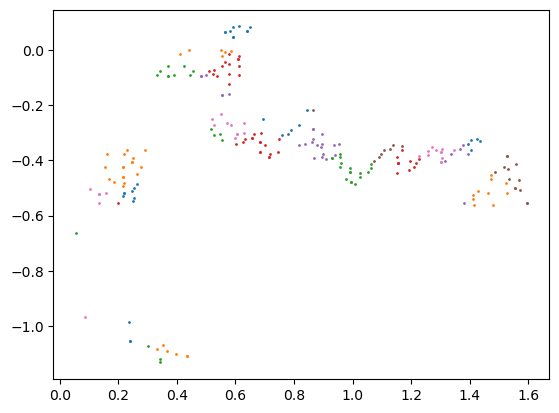

In [14]:
colors = [f'C{i}' for i in range(7)]
for i, (bin_id, g) in enumerate(dataset._df.groupby('bin')):
    plt.scatter(g.ra, g.dec, label=bin_id, color=colors[i%len(colors)], s=1)

# Train

In [15]:
batch_size = 32
num_workers = 4
pin_memory = True if device == 'cuda' else False
trainloader = dataset.get_dataloader(batch_size, num_workers = num_workers, pin_memory = pin_memory)


In [16]:
"""Algorithm and Train setup"""

alg_config = {
    'obs_dim': dataset.obs_dim,
    'num_actions': dataset.num_actions,
    'hidden_dim': 128,
    'device': device,
    'lr': 3e-3,
    'loss_fxn': None, #torch.nn.cross_entropy,
    # 'use_double': True,
}
alg = BehaviorCloning(**alg_config)

fit_config = {
    'num_epochs' : 10,
    'batch_size': batch_size,
    # 'learning_start': 
    }

env_name = 'OfflineEnv'

def create_exp_name(alg, env_name, dataset, fit_config, alg_config):
    exp_name = f"{alg.name}"
    exp_name += f"-{env_name}"
    exp_name += f"-n_nights={dataset.n_nights}"
    # config_prefix += f"-use_double={alg_config['use_double']}"
    exp_name += f"-num_epochs={fit_config['num_epochs']}"
    exp_name += f"-batch_size={fit_config['batch_size']}"
    exp_name += f"-lr={alg_config['lr']}"
    return exp_name

exp_name = create_exp_name(alg, env_name, dataset, fit_config, alg_config)

outdir = f'../results/{exp_name}/'
if not os.path.exists(outdir):
    os.makedirs(outdir)
fig_outdir = outdir + 'figures/'
if not os.path.exists(fig_outdir):
    os.makedirs(fig_outdir)

agent_config = {
    'algorithm': alg,
    'normalize_obs': True,
    'outdir': outdir
    }

agent = Agent(**agent_config)



# Train

In [17]:
# circle on gif is a 1.1deg radius --> maybe nside = 16 is enough, (nside=32 is about a 3 deg area)

In [18]:
start_time = time.time()
"""Train"""
agent.fit(
    dataloader=trainloader,
    **fit_config
    )
end_time = time.time()
train_time = end_time - start_time
print(f'Total train time = {train_time}s')

  0%|                                                  | 0/2290 [00:00<?, ?it/s]/home/hurra/Projects/survey-ops/survey_ops/src/agents.py:130: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  eval_obs = torch.tensor(eval_obs, device=self.device)
/home/hurra/Projects/survey-ops/survey_ops/src/agents.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expert_actions = torch.tensor(expert_actions, device=self.device)
  9%|███▌                                   | 209/2290 [00:00<00:03, 690.64it/s]

Train step 0: Accuracy = 0.000, Loss = 1055.2170, Q-val=0.000
Train step 100: Accuracy = 0.000, Loss = 6.0784, Q-val=0.000
Train step 200: Accuracy = 0.094, Loss = 5.8452, Q-val=0.000


 19%|███████▏                               | 425/2290 [00:00<00:02, 915.24it/s]

Train step 300: Accuracy = 0.031, Loss = 5.4171, Q-val=0.000
Train step 400: Accuracy = 0.031, Loss = 5.0990, Q-val=0.000
Train step 500: Accuracy = 0.031, Loss = 4.6787, Q-val=0.000


 33%|████████████▎                         | 745/2290 [00:00<00:01, 1014.03it/s]

Train step 600: Accuracy = 0.094, Loss = 4.4060, Q-val=0.000
Train step 700: Accuracy = 0.125, Loss = 4.0693, Q-val=0.000
Train step 800: Accuracy = 0.188, Loss = 4.0271, Q-val=0.000


 46%|█████████████████▏                   | 1061/2290 [00:01<00:01, 1028.63it/s]

Train step 900: Accuracy = 0.031, Loss = 3.8242, Q-val=0.000
Train step 1000: Accuracy = 0.094, Loss = 3.5548, Q-val=0.000
Train step 1100: Accuracy = 0.125, Loss = 3.6009, Q-val=0.000


 60%|██████████████████████▎              | 1378/2290 [00:01<00:00, 1049.01it/s]

Train step 1200: Accuracy = 0.219, Loss = 3.6620, Q-val=0.000
Train step 1300: Accuracy = 0.094, Loss = 3.4812, Q-val=0.000
Train step 1400: Accuracy = 0.062, Loss = 3.2263, Q-val=0.000


 74%|███████████████████████████▌         | 1703/2290 [00:01<00:00, 1065.86it/s]

Train step 1500: Accuracy = 0.031, Loss = 3.4463, Q-val=0.000
Train step 1600: Accuracy = 0.062, Loss = 3.3471, Q-val=0.000
Train step 1700: Accuracy = 0.031, Loss = 3.3774, Q-val=0.000


 84%|██████████████████████████████▉      | 1917/2290 [00:01<00:00, 1059.71it/s]

Train step 1800: Accuracy = 0.062, Loss = 3.3343, Q-val=0.000
Train step 1900: Accuracy = 0.062, Loss = 3.3112, Q-val=0.000
Train step 2000: Accuracy = 0.219, Loss = 3.2401, Q-val=0.000


100%|██████████████████████████████████████| 2290/2290 [00:02<00:00, 980.28it/s]

Train step 2100: Accuracy = 0.094, Loss = 3.2126, Q-val=0.000
Train step 2200: Accuracy = 0.094, Loss = 3.0945, Q-val=0.000
Total train time = 2.4284110069274902s


In [19]:
with open(outdir + 'train_metrics.pkl', 'rb') as handle:
    train_metrics = pickle.load(handle)

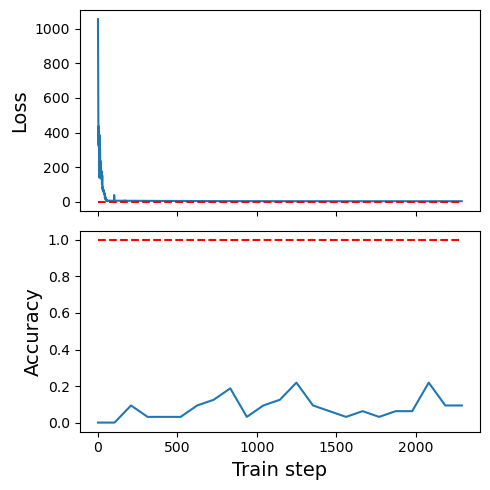

In [20]:
fig, axs = plt.subplots(2, sharex=True, figsize=(5, 5))
axs[0].plot(train_metrics['loss_history'])
axs[0].hlines(y=0, xmin=0, xmax=len(train_metrics['loss_history']), color='red', linestyle='--')
axs[0].set_ylabel('Loss', fontsize=14)
axs[1].plot(np.linspace(0, len(train_metrics['loss_history']), len(train_metrics['test_acc_history'])), train_metrics['test_acc_history'])
axs[1].hlines(y=1, xmin=0, xmax=len(train_metrics['loss_history']), color='red', linestyle='--')
axs[1].set_xlabel('Train step', fontsize=14)
axs[1].set_ylabel('Accuracy', fontsize=14)
axs[1].set_xlabel('Train step', fontsize=14)
fig.tight_layout()
fig.savefig(fig_outdir + 'train_history.png')

# Roll out policy

Actually, instead of getting the trajectory, here we're just giving all of the original schedule's states, and asking what action we should pick

In [21]:
with torch.no_grad():
    q_vals = agent.algorithm.policy_net(dataset.states.to(device))
    eval_actions = torch.argmax(q_vals, dim=1).detach().numpy()
    

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

# Plotting results

In [20]:
from survey_ops.utils.geometry import angular_separation


## First, visualize healpix's gridding and actual ra, dec of observed fields

In [21]:
# get index of the first observation for each night
first_obs_in_night_indices = []
for key, indices in dataset._df.groupby('night').indices.items():
    first_obs_in_night_indices.append(indices[0])

In [22]:
# Sequence of actions from target (original schedule) and policy
target_sequence = dataset.actions.detach().numpy()
eval_sequence = eval_actions

# # Given the action (bin) chosen in the original schedule and in the policy's schedule
# # obtain the angular separation between the two bins for all actions
# target_radec = np.array([dataset.binid2radec[bin_id] for bin_id in target_sequence])
# eval_radec = np.array([dataset.binid2radec[bin_id] for bin_id in eval_sequence])
# # target_angsep = np.array([angular_separation(pos1=target_radec[i]*units.deg, pos2=target_radec[i+1]*units.deg) for i in range(len(target_radec) - 1)]) / units.deg
# # eval_angsep = np.array([angular_separation(pos1=eval_radec[i]*units.deg, pos2=eval_radec[i+1]*units.deg) for i in range(len(target_radec) - 1)]) / units.deg
# target_eval_angsep = np.array([angular_separation(eval_radec[i]*units.deg, pos2=target_radec[i]*units.deg) for i in range(len(target_radec))]) / units.deg

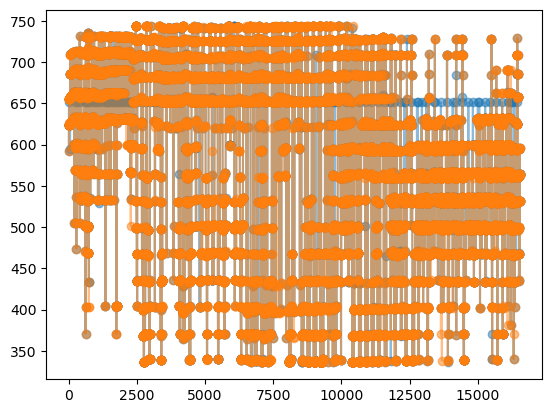

In [23]:
plt.plot(eval_sequence, marker='o', alpha=.5)
plt.plot(target_sequence, marker='o', alpha=.5)

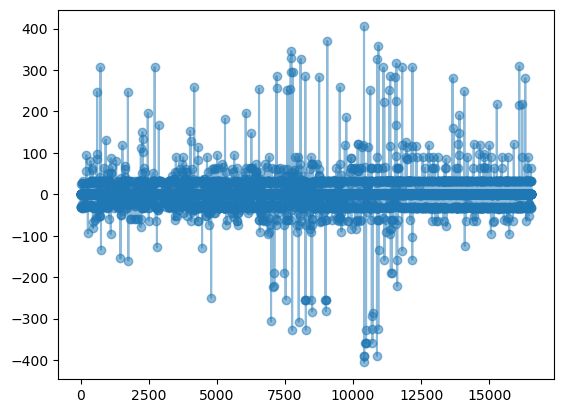

In [24]:
plt.plot(eval_sequence - target_sequence, marker='o', alpha=.5)


NameError: name 'target_eval_angsep' is not defined

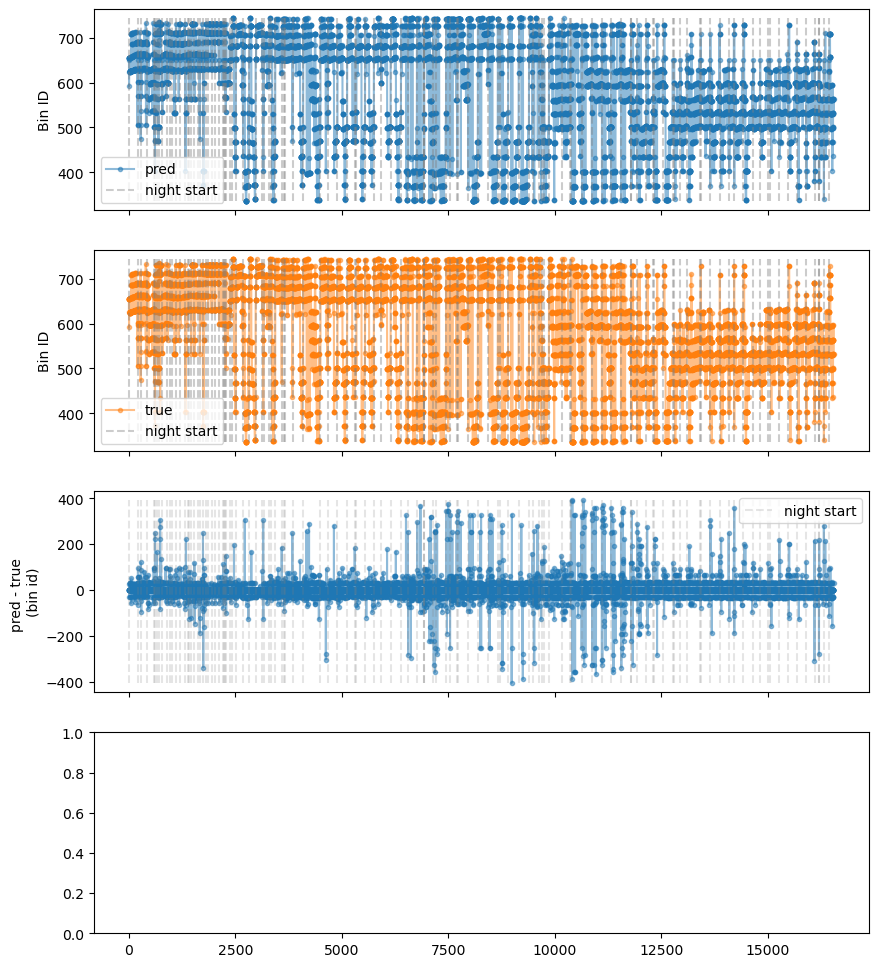

In [23]:
fig, axs = plt.subplots(4, figsize=(10,12), sharex=True)
axs[0].plot(eval_sequence, marker='o', label='pred', alpha=.5, markersize=3)
axs[0].vlines(first_obs_in_night_indices, ymin=np.min(eval_sequence), ymax=np.max(eval_sequence), linestyle='--', color='grey', label='night start', alpha=.4)
axs[0].set_ylabel('Bin ID')
axs[0].legend()

axs[1].plot(target_sequence, marker='o', label='true', color='C1', alpha=.5, markersize=3)
axs[1].vlines(first_obs_in_night_indices, ymin=np.min(target_sequence), ymax=np.max(target_sequence), linestyle='--', color='grey', label='night start', alpha=.4)
axs[1].set_ylabel('Bin ID')
axs[1].legend()

axs[2].plot(eval_sequence - target_sequence, marker='o', alpha=.5, markersize=3)
axs[2].vlines(first_obs_in_night_indices, ymin=np.min(eval_sequence - target_sequence), ymax=np.max(eval_sequence - target_sequence), linestyle='--', color='grey', label='night start', alpha=.2)
axs[2].legend()
axs[2].set_ylabel('pred - true \n(bin id)')

axs[3].plot(target_eval_angsep, marker='o', color='C2', alpha=.5, markersize=3)
axs[3].vlines(first_obs_in_night_indices, ymin=np.min(target_eval_angsep), ymax=np.max(target_eval_angsep), linestyle='--', color='grey', label='night start', alpha=.2)
axs[3].set_xlabel('Observation index')
axs[3].set_ylabel(r'Angular separation $(\degree)$' '\n (between predicted, true)')

fig.tight_layout()
fig.suptitle(f'All of 2014 data, {dataset.n_nights} Nights')
fig.tight_layout()
fig.savefig(fig_outdir + 'learned_sequence.png')